In [ ]:
!sudo apt-get install -y xvfb ffmpeg
!pip3 install mxnet-mkl==1.6.0 numpy==1.23.1
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q --upgrade tensorflow-probability
!pip install -q tf-agents
!pip3 install protobuf

!pip install ipython-autotime
%load_ext autotime

!pip3 uninstall python3-protobuf --yes
!pip3 install protobuf==3.20.* --yes

!pip install --upgrade tensorflow

In [2]:
from __future__ import absolute_import, division, print_function
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import PIL.Image
import pyvirtualdisplay
import numpy as np
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from keras.backend import clear_session

time: 3.92 s (started: 2023-01-24 23:54:24 +00:00)


In [547]:
!pip freeze | grep tensorflow

tensorflow==2.11.0
tensorflow-datasets==4.8.1
tensorflow-estimator==2.11.0
tensorflow-gcs-config==2.9.1
tensorflow-hub==0.12.0
tensorflow-io-gcs-filesystem==0.29.0
tensorflow-metadata==1.12.0
tensorflow-probability==0.19.0
time: 962 ms (started: 2023-01-25 01:31:06 +00:00)


In [548]:
tf.compat.v1.enable_v2_behavior()

seed = 42

clear_session()
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)
tf.experimental.numpy.random.seed(seed)
#common.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

time: 1 s (started: 2023-01-25 01:31:07 +00:00)


In [549]:
display = pyvirtualdisplay.Display(visible = 0, size = (1400, 900)).start()

time: 139 ms (started: 2023-01-25 01:31:08 +00:00)


In [550]:
tf.version.VERSION

'2.11.0'

time: 6.73 ms (started: 2023-01-25 01:31:08 +00:00)


In [551]:
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}

learning_rate = 4e-3  # @param {type:"number"}
#learning_rate = 2.5e-3  # @param {type:"number"}

log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

hidden_neurons = 100 # @param {type:"integer"}
#hidden_neurons = 518 # @param {type:"integer"}

time: 772 µs (started: 2023-01-25 01:31:08 +00:00)


In [552]:
# quantidade de neuronios da camada escondida
fc_layer_params = (hidden_neurons, ) # inicial era 100 neuronios e 1 camada escondida
#fc_layer_params = (hidden_neurons, hidden_neurons, ) # 2 camadas escondidas de 128 cada

time: 315 µs (started: 2023-01-25 01:31:08 +00:00)


In [553]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

time: 2.6 ms (started: 2023-01-25 01:31:08 +00:00)


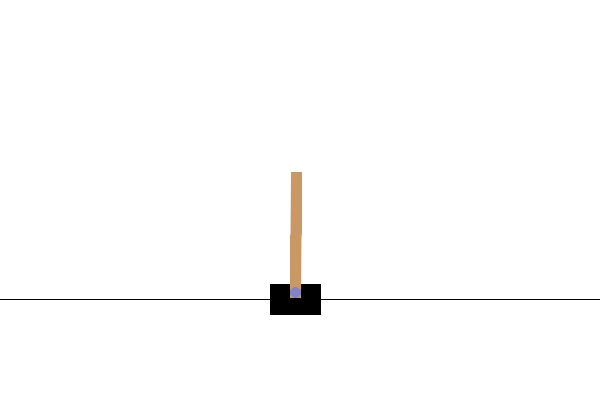

time: 124 ms (started: 2023-01-25 01:31:08 +00:00)


In [554]:
env.reset()
PIL.Image.fromarray(env.render())

In [555]:
# carrega os ambientes de treino e validação
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

time: 3.27 ms (started: 2023-01-25 01:31:08 +00:00)


In [556]:
# transforma os ambientes em objetos do tensorflow
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

time: 14 ms (started: 2023-01-25 01:31:08 +00:00)


In [557]:
# criação da rede neural QNetwork
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params = fc_layer_params)

time: 9.97 ms (started: 2023-01-25 01:31:08 +00:00)


In [558]:
train_env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))

time: 3.59 ms (started: 2023-01-25 01:31:08 +00:00)


In [559]:
# definindo otimizador Adam e taxa de aprendizado
optimizer = tf.compat.v1.train.AdamOptimizer(
    learning_rate = learning_rate
)

train_step_counter = tf.Variable(0)

# criação do agente
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network = q_net,
    optimizer = optimizer,
    td_errors_loss_fn = common.element_wise_squared_loss,
    train_step_counter = train_step_counter)

agent.initialize()

time: 67 ms (started: 2023-01-25 01:31:08 +00:00)


In [560]:
help(tf.compat.v1.train.AdamOptimizer)

Help on class AdamOptimizer in module tensorflow.python.training.adam:

class AdamOptimizer(tensorflow.python.training.optimizer.Optimizer)
 |  AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False, name='Adam')
 |  
 |  Optimizer that implements the Adam algorithm.
 |  
 |  References:
 |    Adam - A Method for Stochastic Optimization:
 |      [Kingma et al., 2015](https://arxiv.org/abs/1412.6980)
 |      ([pdf](https://arxiv.org/pdf/1412.6980.pdf))
 |  
 |  @compatibility(TF2)
 |  tf.compat.v1.train.AdamOptimizer is compatible with eager mode and
 |  `tf.function`.
 |  When eager execution is enabled, `learning_rate`, `beta1`, `beta2`, and
 |  `epsilon` can each be a callable that takes no arguments and returns the
 |  actual value to use. This can be useful for changing these values across
 |  different invocations of optimizer functions.
 |  
 |  To switch to native TF2 style, use [`tf.keras.optimizers.Adam`]
 |  (https://www.tensorflow.org/api

In [561]:
# obtendo a politica de avaliacao e politica de coleta
eval_policy = agent.policy
collect_policy = agent.collect_policy

time: 707 µs (started: 2023-01-25 01:31:08 +00:00)


In [562]:
q_net.summary()

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  500       
_________________________________________________________________
dense_1 (Dense)              multiple                  202       
Total params: 702
Trainable params: 702
Non-trainable params: 0
_________________________________________________________________
time: 958 µs (started: 2023-01-25 01:31:08 +00:00)


In [563]:
# criando politica aleatoria
random_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(),
    train_env.action_spec()
  )

time: 987 µs (started: 2023-01-25 01:31:08 +00:00)


In [564]:
# testando um ambiente de exemplo
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load('CartPole-v0'))

time_step = example_environment.reset()
random_policy.action(time_step)


PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

time: 23 ms (started: 2023-01-25 01:31:08 +00:00)


In [565]:
def compute_avg_return(environment, policy, num_episodes=10):
  """Calcula o retorno medio de cada episodio dada uma politica aplicada em um ambiente."""

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

time: 921 µs (started: 2023-01-25 01:31:08 +00:00)


In [566]:
# avaliando o retorno por episodio de uma politica aleatoria
compute_avg_return(eval_env, random_policy, num_eval_episodes)

22.0

time: 688 ms (started: 2023-01-25 01:31:08 +00:00)


In [567]:
# criando buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = agent.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_max_length
)

time: 22.9 ms (started: 2023-01-25 01:31:09 +00:00)


In [568]:
def collect_step(environment, policy, buffer):
  """Coleta os passos da trajetoria em um buffer."""
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  """Coleta os dados da trajetoria adicionando no buffer passo a passo."""
  for _ in range(steps):
    collect_step(env, policy, buffer)

time: 1.01 ms (started: 2023-01-25 01:31:09 +00:00)


In [569]:
# coleta os dados executando uma politica aleatoria em um ambiente de treino
collect_data(train_env, random_policy, replay_buffer, steps=100)

time: 452 ms (started: 2023-01-25 01:31:09 +00:00)


In [570]:
# converte os dados do buffer em dataset
dataset = replay_buffer.as_dataset(
    num_parallel_calls = 3, 
    sample_batch_size = batch_size, 
    num_steps = 2
).prefetch(3)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

time: 129 ms (started: 2023-01-25 01:31:09 +00:00)


In [571]:
# transforma o dataset em um objeto iterativo
iterator = iter(dataset)

print(iterator)

time: 71.4 ms (started: 2023-01-25 01:31:09 +00:00)


In [572]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 48.03155517578125
step = 400: loss = 16.053611755371094
step = 600: loss = 354.6518249511719
step = 800: loss = 536.356689453125
step = 1000: loss = 586.9580078125
step = 1000: Average Return = 18.799999237060547
step = 1200: loss = 113.83296203613281
step = 1400: loss = 137.94334411621094
step = 1600: loss = 246.0054473876953
step = 1800: loss = 86.14106750488281
step = 2000: loss = 130.11093139648438
step = 2000: Average Return = 35.20000076293945
step = 2200: loss = 213.08663940429688
step = 2400: loss = 26.38907814025879
step = 2600: loss = 17.38094139099121
step = 2800: loss = 13.186692237854004
step = 3000: loss = 49.1881217956543
step = 3000: Average Return = 90.69999694824219
step = 3200: loss = 38.81093215942383
step = 3400: loss = 181.78762817382812
step = 3600: loss = 103.39901733398438
step = 3800: loss = 15.40638542175293
step = 4000: loss = 19.086145401000977
step = 4000: Average Return = 29.299999237060547
step = 4200: loss = 159.3167266845703
step = 4

(1.549999999999999, 250.0)

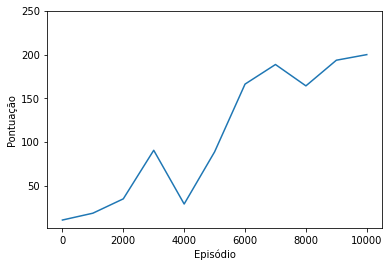

time: 124 ms (started: 2023-01-25 01:34:28 +00:00)


In [573]:
# visualizando o retorno durante o treinamento
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Pontuação')
plt.xlabel('Episódio')
plt.ylim(top=250)

In [574]:
print(returns)

[11.0, 18.8, 35.2, 90.7, 29.3, 88.9, 166.3, 188.7, 164.3, 193.6, 200.0]
time: 1.02 ms (started: 2023-01-25 01:34:28 +00:00)


In [575]:
# esse código gera o erro

"""
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)
state = env.reset()
#init_state = [0,0,-3,0]
#env.env.state = init_state
theta= []
theta_dot = []
x = []
x_dot = []
#env.render()

contagem = 0
for t in range(200000):
    action_step = agent.policy.action(state)
    #env.render()
    state, reward, done, _ = env.step(action.action)
    theta.append(state[2])
    theta_dot.append(state[3])
    x_dot.append(state[1])
    x.append(state[0])
    if done:
        contagem += 1
        if contagem == 1000:
            break
env.close()

"""

"\nenv_name = 'CartPole-v0'\nenv = suite_gym.load(env_name)\nstate = env.reset()\n#init_state = [0,0,-3,0]\n#env.env.state = init_state\ntheta= []\ntheta_dot = []\nx = []\nx_dot = []\n#env.render()\n\ncontagem = 0\nfor t in range(200000):\n    action_step = agent.policy.action(state)\n    #env.render()\n    state, reward, done, _ = env.step(action.action)\n    theta.append(state[2])\n    theta_dot.append(state[3])\n    x_dot.append(state[1])\n    x.append(state[0])\n    if done:\n        contagem += 1\n        if contagem == 1000:\n            break\nenv.close()\n\n"

time: 5.67 ms (started: 2023-01-25 01:34:28 +00:00)


In [576]:
def embed_mp4(filename):
  """Anexa video mp4 no jupyter notebook."""
  
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

time: 1.03 ms (started: 2023-01-25 01:34:28 +00:00)


In [577]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"

  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      init_state = [0,0,0.2,0]
      eval_env.pyenv.set_state = init_state
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
        
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

time: 10.9 s (started: 2023-01-25 01:34:28 +00:00)


In [578]:
def create_policy_eval(policy, num_episodes=1):
  states = []
  time_step = eval_env.reset()
  init_state = [0,0,0.2,0]
  #eval_env.state = init_state
  eval_env.pyenv.set_state = init_state
  for _ in range(200):
    action_step = policy.action(time_step)
    time_step = eval_env.step(action_step.action)
    states.append(time_step)
  return states




states = create_policy_eval(agent.policy)

time: 1 s (started: 2023-01-25 01:34:39 +00:00)


In [579]:
st = []
for i in range(len(states)):
  st.append(states[i][3]) 

time: 998 µs (started: 2023-01-25 01:34:40 +00:00)


In [580]:
estados = np.array(st)

time: 1.87 ms (started: 2023-01-25 01:34:40 +00:00)


In [581]:
len(estados[:,0,:])

200

time: 5.83 ms (started: 2023-01-25 01:34:40 +00:00)


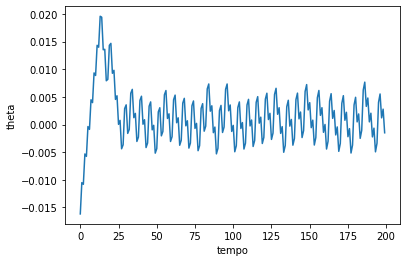

time: 135 ms (started: 2023-01-25 01:34:40 +00:00)


In [582]:
theta = estados[:,0,2]
theta_dot = estados[:,0,3]
x = estados[:,0,0] 
x_dot = estados[:,0,1] 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(theta)
plt.ylabel('theta')
plt.xlabel('tempo')
plt.show()

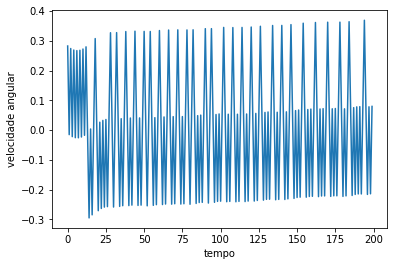

time: 136 ms (started: 2023-01-25 01:34:40 +00:00)


In [583]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(theta_dot)
plt.ylabel('velocidade angular')
plt.xlabel('tempo')
plt.show()

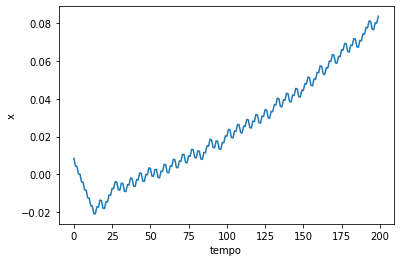

time: 122 ms (started: 2023-01-25 01:34:41 +00:00)


In [584]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x)
plt.ylabel('x')
plt.xlabel('tempo')
plt.show()

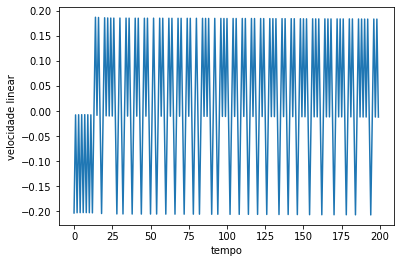

time: 121 ms (started: 2023-01-25 01:34:41 +00:00)


In [585]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x_dot)
plt.ylabel('velocidade linear')
plt.xlabel('tempo')
plt.show()

In [586]:
#print(estados[:,0,:])

time: 528 µs (started: 2023-01-25 01:34:41 +00:00)


(1.549999999999999, 250.0)

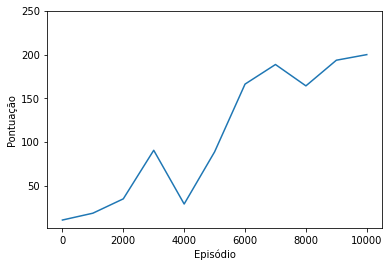

time: 126 ms (started: 2023-01-25 01:34:41 +00:00)


In [587]:
# visualizando o retorno durante o treinamento
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Pontuação')
plt.xlabel('Episódio')
plt.ylim(top=250)

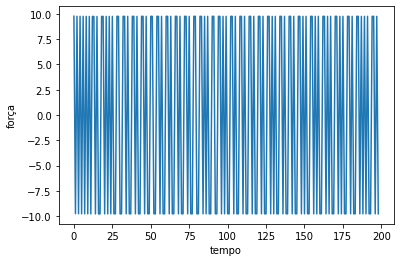

time: 128 ms (started: 2023-01-25 01:34:41 +00:00)


In [588]:
# Força

forca = np.diff(x_dot)
plt.plot(forca * 50)
plt.ylabel('força')
plt.xlabel('tempo')
plt.show()



In [589]:
data = {
    'theta': estados[:,0,2],
    'theta_dot': estados[:,0,3],
    'x': estados[:,0,0],
    'x_dot': estados[:,0,1] 
}

time: 880 µs (started: 2023-01-25 01:51:11 +00:00)


In [590]:
import pandas as pd


time: 605 µs (started: 2023-01-25 01:51:33 +00:00)


In [591]:
df = pd.DataFrame(data)

time: 14.7 ms (started: 2023-01-25 01:52:21 +00:00)


In [595]:
df

,theta,theta_dot,x,x_dot
0,-0.016166,0.282758,0.008445,-0.203021
1,-0.010511,-0.014979,0.004385,-0.007672
2,-0.010811,0.274369,0.004231,-0.202642
3,-0.005324,-0.021704,0.000179,-0.007367
4,-0.005758,0.269294,0.000031,-0.202412
...,...,...,...,...
195,0.004010,0.075603,0.076799,-0.011778
196,0.005522,-0.215812,0.076564,0.183286
197,0.001206,0.078608,0.080230,-0.011915
198,0.002778,-0.213694,0.079991,0.183190


time: 41.3 ms (started: 2023-01-25 01:54:45 +00:00)


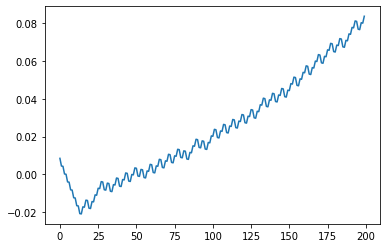

time: 337 ms (started: 2023-01-25 01:55:19 +00:00)


In [596]:
df.x.plot()

In [597]:
df.to_csv('data.csv')

time: 8.99 ms (started: 2023-01-25 01:56:06 +00:00)


In [598]:
df_return = pd.DataFrame(
    {'iterations':iterations, 'returns':returns}
)

time: 1.53 ms (started: 2023-01-25 01:59:31 +00:00)


In [599]:
df_return.to_csv('return.csv')

time: 3.52 ms (started: 2023-01-25 01:59:55 +00:00)
